# Object recognition pipeline

The pipeline is based on few models/frameworks:


**BLIP-2** - image captioning ([paper](https://arxiv.org/pdf/2301.12597), [HuggingFace](https://huggingface.co/docs/transformers/main/en/model_doc/blip_2)).


**spaCY** - english text analyser (https://spacy.io/).


**GroundingDINO/SAM** - object detection and segmentation.




## Set-up environment

In [1]:
!pip install transformers

## Load an image

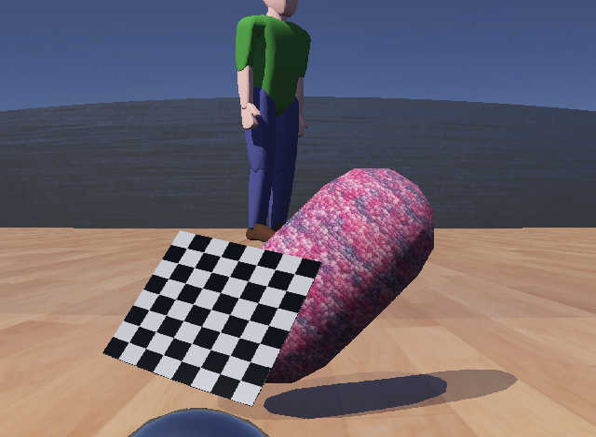

In [2]:
import requests
from PIL import Image

url = 'https://raw.githubusercontent.com/ant-nik/semares/master/data/stereo-camera-cyl/image68_r.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
display(image.resize((596, 437)))

## Loading BLIP 2 model

There are model and checkpoints in HuggingFace.The model and its processor can be found at [hub](https://huggingface.co/models?other=blip-2). Also it is require d to load a checkpoint (pre-trained OPT model by Meta AI, which as 2.7 billion parameters).

In [3]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
# optimize RAM by using float16
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

A GPU improves a performance.

In [4]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

## List objects on an image with BLIP 2

No prompt is required if we only want to captionize an image.

In [70]:
prompt = "Question: What objects are in the image? Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


a ball, a checkerboard, a person, and a ball


Examples of a context (a chat-like dialogue) - describe objects from previous step.

In [71]:
 # "a ball, a checkerboard, a person, and a ball."
context = f"{prompt} {generated_text}"
chat_prompt = f"{context}. Question: Which color is a person's pants? Answer:"
inputs = processor(image, text=chat_prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


blue.
